# Inport Packages

In [0]:
import cv2# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import utils

In [0]:
import numpy
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import pickle
import os
import random


In [0]:
use_gpu = True

# Import train and test pkl

In [5]:
from google.colab import files

uploaded = files.upload()

In [6]:
!ls

datalab  test.pkl  train.pkl


# Codes

In [0]:
cls = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

In [0]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

class Emotional(torch.utils.data.TensorDataset):

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = (self.X[idx]/255.0).astype(float)

#         if self.transform:
#             image = self.transform(transform)

        sample = [image, self.y[idx]]

        return sample


In [0]:
with open('test.pkl', 'rb') as f:
    test = pickle.load(f)
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)

In [0]:
train_loader = torch.utils.data.DataLoader(train, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=20, shuffle=False)

torch.Size([20, 1, 64, 64]) <class 'torch.DoubleTensor'> torch.Size([20]) <class 'torch.LongTensor'>


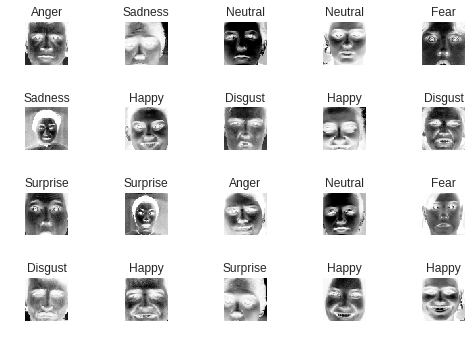

In [11]:
for idx, (x, y) in enumerate(train_loader):
    print(x.shape, type(x), y.shape, type(y))
    for i in range(len(x)):
        plt.subplot(4, len(x)/4, i+1)
        plt.subplots_adjust(wspace=1, hspace=1)
        plt.imshow(x[i].numpy()[0])
        plt.axis('off')
        plt.title(cls[y[i]])
    if idx == 0:
        break

plt.show()

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*4*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [3,3,3,3])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


# def test():
#     net = ResNet18()
#     y = net(Variable(torch.randn(1,1,64,64))) #1 sample 3 channel 32*32 image
#     print(y.size())
#     print(net)

# test()


In [0]:
# model = Model()
model = ResNet18()

In [0]:
if use_gpu:
    model.cuda()
    #model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

In [15]:
print(model)

ResNet(
  (conv1): Conv2d (1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (shortcut): Sequential(
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (shortcut): Sequential(
      )
    )
    (2): BasicBlock(
      (conv1): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [0]:
def train(epoch):
    print('Epoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.float()
        if use_gpu:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
#         print(outputs.data,'ooo')
#         print(torch.max(outputs.data, 1),'yyyyy')
#         print(outputs.data.cpu().numpy().argsort(),'xxxxx')
#         print([i.argsort()[-2:] for i in outputs.data.cpu().numpy()], 'xxxx')
        
        total += targets.size(0)
#         correct += predicted.eq(targets.data).cpu().sum()
        for true, pred in zip(targets.data.cpu().numpy(),outputs.data.cpu().numpy()):
            if true in pred.argsort()[-2:]:
              correct += 1

    print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.float()
        if use_gpu:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
#         correct += predicted.eq(targets.data).cpu().sum()
        for true, pred in zip(targets.data.cpu().numpy(),outputs.data.cpu().numpy()):
            if true in pred.argsort()[-2:]:
              correct += 1

    print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [18]:
start_epoch = 0
import time
for epoch in range(start_epoch, start_epoch+25):
    start_time = time.time()
    train(epoch)
    print("--- %s seconds ---" % (time.time() - start_time))
    test(epoch)

Epoch: 0
Loss: 2.005 | Acc: 37.664% (719/1909)
--- 24.150710105895996 seconds ---
Loss: 3.088 | Acc: 32.845% (157/478)
Epoch: 1
Loss: 1.851 | Acc: 45.783% (874/1909)
--- 20.687119245529175 seconds ---
Loss: 1.986 | Acc: 45.397% (217/478)
Epoch: 2
Loss: 1.708 | Acc: 55.107% (1052/1909)
--- 20.69358468055725 seconds ---
Loss: 2.358 | Acc: 48.536% (232/478)
Epoch: 3
Loss: 1.528 | Acc: 63.122% (1205/1909)
--- 20.70619249343872 seconds ---
Loss: 1.600 | Acc: 62.762% (300/478)
Epoch: 4
Loss: 1.282 | Acc: 73.494% (1403/1909)
--- 20.703165292739868 seconds ---
Loss: 1.382 | Acc: 69.874% (334/478)
Epoch: 5
Loss: 1.066 | Acc: 79.990% (1527/1909)
--- 20.726598978042603 seconds ---
Loss: 1.519 | Acc: 76.360% (365/478)
Epoch: 6
Loss: 0.860 | Acc: 87.742% (1675/1909)
--- 20.71893334388733 seconds ---
Loss: 1.299 | Acc: 74.477% (356/478)
Epoch: 7
Loss: 0.752 | Acc: 89.785% (1714/1909)
--- 20.721408128738403 seconds ---
Loss: 1.008 | Acc: 82.636% (395/478)
Epoch: 8
Loss: 0.568 | Acc: 94.762% (1809/190

In [19]:
torch.save(model.cpu(),'./resnet18.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
!ls

datalab  resnet18.pt  test.pkl	train.pkl


In [0]:
from google.colab import files

files.download('resnet18.pt')